<a href="https://colab.research.google.com/github/blackJJW/DL/blob/main/self_study_DL/chapter7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book : '혼자 공부하는 머신러닝 + 딥러닝', 박해선 지음, 한빛미디어

# 07-3 신경망 모델 훈련

## 손실 곡선

- 케라스의 fit() 메서드는 HIstory 클래스를 반환
- History 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있음.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state = 42
)

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
def model_fn(a_layer = None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))

  if a_layer:
    model.add(a_layer)
  
  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

- if 구문 제외, 이전 절에서 만든 것과 동일한 모델 생성
- if 구문의 역할 : model_fn() 함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것.

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


- fit() 메서드의 결과를 history 변수에 저장

In [4]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 5, verbose = 0)

> verbose = 0
- verbose : 훈련 과정 출력 조절
- 기본값 = 1, 에포크마다 진행 막새돠 함께 손실 등의 지표가 출력.
- 2 : 진행 막대를 빼고 출력.
- 0 : 훈련 과정 출력 안함.

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


- history 딕셔너리에 loss와 accuracy가 저장.

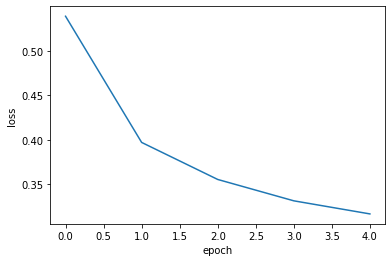

In [6]:
# 손실도 그래프
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

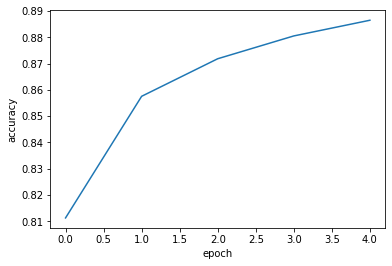

In [7]:
# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- 에포크마다 손실이 감소하고 정확도가 상승.

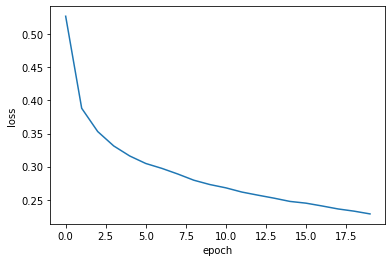

In [8]:
model = model_fn()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

> 손실을 사용하는 것과 정확도를 사용하는 것.
- 인공 신경망 모델이 최적화하는 대사이 정확도가 아니라 손실 함수.
- 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 좋음.

- 에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달 가능.
- 다음 처럼 validation_data 매개변수에 검즈에 사용할 입력과 타깃값을 튜플로 만들어 전달.

In [10]:
model = model_fn()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, 
                    validation_data = (val_scaled, val_target))

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


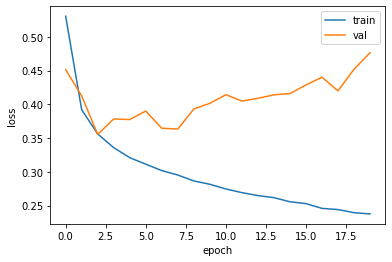

In [12]:
# val_loss : 검증 세트에 대한 손실
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 훈련 손실은 꾸준히 감소 -> 전형적인 과대적합 모델.
- 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들고, 정확도도 증가할 것.

- 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시킬 수 있는가?
- 기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작.
- Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정 가능.

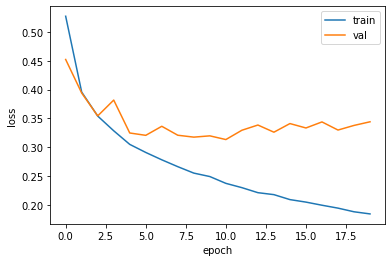

In [13]:
model = model_fn()
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
              metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, 
                    validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합이 줄어들어듬.
- Adam 옵티마이저가 이 데이터 셋에 잘 맞음.

## 드롭아웃(dropout)

- 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어) 과대적합을 막음.
- 뉴런은 랜덤하게 드롭아웃되고 얼마나 많은 뉴런을 드롭할지 정하는 하이퍼파라미터.

- 과대적합을 막는 이유 
  - 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대한 주의를 기울여야 함.
  - 드롭아웃이 적용된 2개의 신경망을 훈련하는 것은 2개의 신경망을 앙상블하는 것과 비슷.

In [16]:
model = model_fn(keras.layers.Dropout(0.3)) 
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


- 드롭아웃 층은 훈련되는 파라미터가 없음.
- 입력과 출력이 같음.
- 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지 않음.

- 훈련이 끝난 뒤, 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 함.
- 훈련된 모든 뉴런을 사용해야 올바른 예측 수행 가능.

- 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않음.

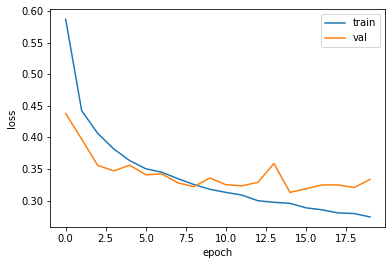

In [17]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
              metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0, 
                    validation_data = (val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대 적합이 줄어들어듬.

## 모델 저장과 복원

- 에포크 횟수를 10으로 다시 지정하고 모델을 훈련.

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
              metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 10, verbose = 0, 
                    validation_data = (val_scaled, val_target))

- 케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드 제공.
- 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장.

In [19]:
model.save_weights('model-weights.h5')

- 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드
- 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장.

In [20]:
model.save('model-whole.h5')

- 저장 모델 확인

In [21]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Apr 24 17:53 model-weights.h5
-rw-r--r-- 1 root root 982664 Apr 24 17:55 model-whole.h5


- 첫 번째 실험
  - 훈련을 하지 않은 새로운 모델 생성, model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용.

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

> 모델 파라미터를 적재하는 조건
- load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야함.

- 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환.
  - 사용하고 있는 데이터셋이 다중 분류이기 때문.
  - 이진 분류 문제라면 양성 클래스에 대한 확률 하나만 반환.
- 패션 MNIST 데이터셋에서 덜어낸 검중 세트의 샘플 개수는 12,000개이기 때문에 predict() 메서드는 (12000, 10) 크기의 배열을 반환.

- 10개 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산.

In [23]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis = -1)
print(np.mean(val_labels == val_target))

0.8801666666666667


- 가장 큰 값을 고르기 위해 argmax()함수 사용.
  - 배열에서 가장 큰 값의 인덱스를 반환.
  - axis=-1 은 배열의 마지막 차원을 따라 최댓값을 고름.

- 두 번째 실험
  - 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도 출력.

In [25]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3321 - accuracy: 0.8802


[0.33207204937934875, 0.8801666498184204]

- 같은 모델을 저장하고 불렀기 때문에 동일한 정확도를 출력.

## 콜백(callback)

- 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체.
- keras.callbacks 패키지 아래에 존재.
- fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용.

- ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장.
- save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 저장 가능.

In [26]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
              metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
model.fit(train_scaled, train_target, epochs = 20, verbose = 0, 
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb])

In [27]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.3191 - accuracy: 0.8852


[0.3190595805644989, 0.8852499723434448]

- ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장.
  - 하지만 에포크 20번 모두 수행함.
  - 검증 점수가 상승하기 시작하면 과대적합이 더 커지기 때문에 훈련을 계속할 필요 없음.
    - 이 때 훈련을 중지하면 자원과 시간을 아낄 수 있음.
    - 과대적합이 시작되기 전에 훈련을 미리 중지하는 것 -> 조기 종료(early stopping)

- 조기 종료는 훈련 에포크 횟수를 제한하는 역할을 하지만 모델이 과대적합되는 것을 막아 주기 때문에 규제 방법 중 하나로 생각할 수 있음.

- 케라스에서는 조기 종료를 위한 EarlyStopping 콜백을 제공.
  - patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정.
  - restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림.

- EarlyStopping과 ModelCheckpoint를 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련 중지 가능.
- 또한, 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌림.

In [28]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
              metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, 
                                                  restore_best_weights=True)
model.fit(train_scaled, train_target, epochs = 20, verbose = 0, 
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

- 몇 번째 에포크에서 멈췄는 지 확인 : early_stopping_cb 객체의 stopped_epoch 속성에서 확인.

In [29]:
print(early_stopping_cb.stopped_epoch)

12


- patience = 2 로 지정했기 때문에 최상의 모델은 11번 째 에포크.

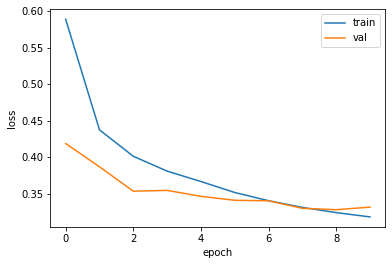

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능 확인.

In [31]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 4ms/step - loss: 0.3212 - accuracy: 0.8839


[0.3211706578731537, 0.8839166760444641]

## 마무리

### 키워드로 끝내는 핵심 포인트

- 드롭아웃 : 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법.
  - 훈련 중에 적용되며 평가나 예측에 사용하지 않음.
- 콜백 : 케라스 모델을 훈련하는 도중에 어떤 작업을 수행할 수 있도록 도와주는 도구.
  - 대표적으로 최상의 모델을 자동으로 저장해 주거나 검증 점수가 더 이상 향상되지 않으면 일찍 종료 가능.
- 조기 종료 : 검증 점수가 더 이상 감소하지 않고 상승하여 과대 적합이 일어나면 훈련을 계속 진행하지 않고 멈추는 기법.
  - 계산 비용과 시간 절약.

### 핵심 패키지와 함수

> TensorFlow
- DropOut : 드롭아웃 층
  - 첫 번째 매개변수로 드롭아웃 할 비율(r)을 지정.
  - 드롭아웃하지 않는 뉴런의 출력은 1/(1 - r) 만큼 증가시켜 출력의 총합이 같도록 만듬.
- save_weights() : 모든 층의 가중치와 절편을 파일에 저장.
  - 첫 번째 매개변수에 저장할 파일을 지정.
  - save_format : 저장할 파일 형식 지정.
    - 기본적으로 텐서플로의 Checkpoint 포멧을 사용.
    - 'h5'로 지정하거나 파일의 확장자가 '.h5'이면 HDF5 포맷으로 저장.
- load_weights() : 모든 줄의 가중치와 절편을 파일에 읽음.
  - 첫 번째 매개변수에 읽을 파일을 지정.
- save() : 모델 구조와 모든 가중치와 절편을 파일에 저장.
  - 첫 번째 매개변수에 저장할 파일을 지정
  - save_format : 저장할 파일 형식 지정.
    - 기본적으로 텐서플로의 SavedModel 포멧을 사용.
    - 'h5'로 지정하거나 파일의 확장자가 '.h5'이면 HDF5 포맷으로 저장.
- load_model() : model.save()로 저장된 모델을 로드.
  - 첫 번째 매개변수에 읽을 파일을 지정.
- ModelCheckpoint : 케라스 모델과 가중치를 일정 간격으로 저장.
  - 첫 번째 매개변수에 저장할 파일을 지정
  - monitor : 모니터링할 지표를 지정.
    - 기본값 = 'val_loss' : 검증 손실을 관찰
    - save_weights_only : 기본값 = False -> 전체 모델 저장.
      - True : 모델의 가중치와 절편만 저장.
    - save_best_only : True로 지정하면 가장 낮은 점수를 만드는 모델 저장.
- EarlyStopping : 관심 지표가 더이상 향상하지 않으면 훈련을 중지.
  - monitor : 모니터링할 지표를 지정.
    - 기본값 = 'val_loss' : 검증 손실을 관찰
  - patience : 모델이 더 이상 향상되지 않고 지속할 수 있는 최대 에포크 횟수를 지정.
  - restore_best_weights : 최상의 모델 가중치를 복원할지 지정.
    - 기본값 = False    

> Numpy
- argmax : 배열에서 축을 따라 최댓값의 인덱스를 반환.
  - axis : 어떤 축을 따라 최댓값을 찾을지 지정.
    - 기본값 = None : 전체 배열에서 최댓값을 찾음.